In [279]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import cmath
from scipy.stats import qmc
from concurrent.futures import ThreadPoolExecutor, as_completed

### Implementation of the Mandelbrot Set
---

In [280]:
def mandelbrot(z, c):
	"""Calculates the next iteration of the mandelbrot set according to z^2 + c.

	Args:
		z (float): complex coordinate of the previous iteration
		c (float): complex coordinate of starting point

	Returns:
		float: coordinate of next iteration in the complex plane.
	"""	
	return add_complex(square_complex(z), c)

def square_complex(z):
	"""Calculates the square of a complex number: (a + bi)^2

	Args:
		z (float): complex number

	Returns:
		float: square of a complex number
	"""	
	return complex(z.real**2 - z.imag**2, 2*z.real*z.imag)

def add_complex(z1, z2):
	"""Adds two complex numbers: a+bi + c+di = a+b + (b+d)i

	Args:
		z1 (float): complex number 1
		z2 (float): complex number 2

	Returns:
		float: result of z1 + z2
	"""	
	return complex(z1.real + z2.real, z1.imag + z2.imag)

def magnitude_complex(z):
	"""Calculates the magnitude of  a complex number: |z| = sqrt(a^2 + b^2)

	Args:
		z (float): complex number

	Returns:
		float: magnitude of z 
	"""	
	return np.sqrt(z.real**2 + z.imag**2)

In [281]:
def mandelbrot_plot(resolution, max_length_set, re_min, re_max, im_min, im_max):
	"""For a given resolution and range of real and imaginary numbers, a matrix is generated based on the number of iterations it takes to diverge (or not).

	Args:
		resolution (int): number of points in the real and imaginary range
		max_length_set (int): maximum number of iterations per starting point
		re_min (float): start of real range
		re_max (float): end or real range
		im_min (float): start of imaginary range
		im_max (float): end of imaginary range

	Returns:
		ndarray: matrix to visualise the mandelbrot set
	"""	
	real_range = np.linspace(re_min, re_max, resolution)
	imaginary_range = np.linspace(im_min, im_max, resolution)
	mat = np.full((resolution, resolution), max_length_set)

	# creates a contour plot in a horizontal direction.
	for i, im in enumerate(imaginary_range):
		for j, re in enumerate(real_range):
			c = complex(re, im)
			z = complex(0, 0)

			# checks after how many iteration the complex number diverges. if k=max_lengths_set, then no divergence.
			for k in range(max_length_set):
				z = mandelbrot(z, c)
				if magnitude_complex(z) > 2:
					mat[i, j] = k
					break

	return mat

In [ ]:
mandelplot = mandelbrot_plot(resolution=1000, max_length_set=100, re_min=-2, re_max=0.6, im_min=-1.25, im_max=1.25)
mandelplot_zoom = mandelbrot_plot(resolution=1000, max_length_set=100, re_min=-0.65, re_max=-0.25, im_min=0.45, im_max=0.75)
mandelplot_zoom2 = mandelbrot_plot(resolution=1000, max_length_set=100, re_min=-0.48, re_max=-0.45, im_min=0.59, im_max=0.62)

In [ ]:
# Original
plt.figure(figsize=(8, 8))
plt.imshow(mandelplot, extent=[-2, 0.6, -1.25, 1.25])
plt.xlabel('Real numbers', fontsize=13)
plt.ylabel('Imaginary numbers', fontsize=13)
plt.show()

# Zoomed
plt.figure(figsize=(8, 8))
plt.imshow(mandelplot_zoom, extent=[-0.65, -0.25, 0.45, 0.75])
plt.xlabel('Real numbers', fontsize=13)
plt.ylabel('Imaginary numbers', fontsize=13)
plt.show()

# Even more zoom
plt.figure(figsize=(8, 8))
plt.imshow(mandelplot_zoom2, extent=[-0.48, -0.45, 0.59, 0.62])
plt.xlabel('Real numbers', fontsize=13)
plt.ylabel('Imaginary numbers', fontsize=13)
plt.show()

### Implementation of Sampler
---

In [283]:
class MBSampler:
    def __init__(self, re_min, re_max, im_min, im_max):
        self.bounds = {
            "re_min": re_min,
            "re_max": re_max,
            "im_min": im_min,
            "im_max": im_max
        }


    def sample(self, method, num_samples, seed):
        match method:
            case "UNIRAND":
                return self.uniform_random(num_samples, seed)
            case "OHC":
                return self.orthogonal(num_samples, seed)
            case "LHC":
                return self.latin_hypercube(num_samples, seed)
            case "SOBEL":
                return self.sobol(num_samples, seed)
            case _:
                raise ValueError("Unknown Sampling Method")

    def uniform_random(self, num_samples, seed):
        np.random.seed(seed)
        c_re = np.random.uniform(self.bounds["re_min"], self.bounds["re_max"], num_samples)
        c_im = np.random.uniform(self.bounds["im_min"], self.bounds["im_max"], num_samples)
        c_array = c_re + 1j * c_im
        return c_array, c_re, c_im

    def orthogonal(self, num_samples, seed):
        orth = qmc.LatinHypercube(d=2, strength=2, seed=seed)
        samples = orth.random(n=num_samples)
        scaled_samples = qmc.scale(samples,
                                   [self.bounds["re_min"], self.bounds["im_min"]],
                                   [self.bounds["re_max"], self.bounds["im_max"]])
        c_re = scaled_samples[:, 0]
        c_im = scaled_samples[:, 1]
        c_array = c_re + 1j * c_im
        return c_array, c_re, c_im

    def latin_hypercube(self, num_samples, seed):
        lhc = qmc.LatinHypercube(d=2, seed=seed)
        samples = lhc.random(n=num_samples)
        scaled_samples = qmc.scale(samples,
                                   [self.bounds["re_min"], self.bounds["im_min"]],
                                   [self.bounds["re_max"], self.bounds["im_max"]])
        c_re = scaled_samples[:, 0]
        c_im = scaled_samples[:, 1]
        c_array = c_re + 1j * c_im
        return c_array, c_re, c_im

    def sobol(self, num_samples, seed):
        if not (num_samples and (num_samples & (num_samples - 1)) == 0):
            raise ValueError("For Sobol sampling, num_samples must be a power of 2.")
        sobol = qmc.Sobol(d=2, seed=seed)
        samples = sobol.random(n=num_samples)
        scaled_samples = qmc.scale(samples,
                                   [self.bounds["re_min"], self.bounds["im_min"]],
                                   [self.bounds["re_max"], self.bounds["im_max"]])
        c_re = scaled_samples[:, 0]
        c_im = scaled_samples[:, 1]
        c_array = c_re + 1j * c_im
        return c_array, c_re, c_im

In [285]:
def valid_sobol_sample_sizes(max_samples=1024):
    sample_sizes = []
    n = 1
    while 2 ** n <= max_samples:
        sample_sizes.append(2 ** n)
        n += 1
    return sample_sizes

In [313]:
# Square of primes: 43**2 ~ 1800 samples
sample_range = np.array([2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43])**2
sobol_sample = valid_sobol_sample_sizes(1024)

re_min, re_max = -2.0, 2.0
im_min, im_max = -2.0, 2.0

sampler = MBSampler(re_min=re_min, re_max=re_max, im_min=im_min, im_max=im_max)
sampler.sample(method="UNIRAND", num_samples=sample_range[3], seed = 2)
sampler.sample(method="SOBEL", num_samples=sobol_sample[3], seed =1)
sampler.sample(method="OHC", num_samples=sample_range[3], seed =1)
sampler.sample(method="LHC", num_samples=sample_range[3], seed =4)

(array([-0.52596376-1.47031245j, -1.75316275-0.29231314j,
         0.15450156-1.29603972j,  0.46515092+1.1694263j ,
        -1.98952125+1.38416805j,  0.94675795-0.16140029j,
        -0.89228541-1.16644463j, -1.4272778 -0.72405925j,
        -0.03828023-0.52481848j, -0.70838307+0.64417538j,
        -0.66978488+0.37201603j,  1.04770144+1.58094729j,
        -1.46921368-0.24437713j,  1.95916521-1.42519039j,
        -0.55917856+1.73683501j, -1.14466016-0.90948334j,
        -1.83176384-0.65975639j,  0.42711564+0.12818166j,
        -0.24422247-0.83067762j, -0.07967665+1.32922612j,
         0.63734269-1.98127596j, -1.52577865+1.88082318j,
         0.09291306+0.27177716j, -0.38541646+0.28877491j,
         0.21353281-1.21488097j,  1.85800218+0.77208424j,
         0.78244431-0.98262619j, -0.35267492-0.0633419j ,
         1.4795001 -1.86514643j,  0.85939268+0.4955543j ,
         1.55104549-0.44538604j,  0.70177995+1.23306037j,
        -0.96386595+1.93411854j,  1.41979824-1.5422195j ,
         1.765

### Implementation of Monte Carlo
---

In [271]:
def monte_carlo(num_iterations, num_samples, convergence_criterion, re_min, re_max, im_min, im_max, sampling_method='random'):
    # Initialize arrays to store areas and sampling points
    areas = np.zeros((num_iterations, num_samples))
    sampling = np.zeros((num_iterations, num_samples, 3))  # Stores real and imaginary parts, and if inside the set

    # Calculate the area of the integration box
    area_integration_box = np.abs(re_max - re_min) * np.abs(im_max - im_min)

    for i in range(num_iterations):
        # Sample points using the provided MBSampler instance
        sampler = MBSampler(re_min, re_max, im_min, im_max)
        c_array, c_re, c_im = sampler.sample(num_samples=num_samples, method=sampling_method, seed = i)

        points_inside = 0
        for j in range(num_samples):
            z = complex(0, 0)
            in_set = True

            # Manual convergence check
            for k in range(convergence_criterion):
                z = z**2 + c_array[j]
                if abs(z) > 2:
                    in_set = False
                    break

            sampling[i, j, :] = c_re[j], c_im[j], int(in_set)
            points_inside += int(in_set)

        # Calculate area estimate for this iteration
            areas[i,j] = area_integration_box * ((points_inside/(num_samples)))

    return areas, sampling



In [343]:
def monte_carlo(num_iterations, num_samples, max_length_set, re_min, re_max, im_min, im_max, sampling_method='random'):
	#max length set hernoemen naar convergence criterium
	# num iterations is the number of times the same number of samples is repeated for an average
	areas = np.ndarray(shape=(num_iterations, num_samples))
	# on the third dimension, the coordinates are stored in the [a,b,0] (real) and [a,b,1](imaginary) and if it is within the set, store a 1 (if not a 0) on [,,3]
	sampling = np.ndarray(shape=(num_iterations, num_samples, 3))  # on the third dimension, the coordinates are stored in the [,,0] and [,,1] and if it is within the set, store a 1 (if not a 0) on [,,3]
	area_integration_box = np.abs(re_max-re_min) * np.abs(im_max-im_min)   # suggestion np. abs after the product is sufficient

	for i in range(num_iterations):
		sampler = MBSampler(re_min, re_max, im_min, im_max)
		c_array, c_re, c_im = sampler.sample(num_samples=num_samples, method=sampling_method, seed = i)

		points_outside = 0
		for j in range(num_samples):
			z = complex(0,0)

			for k in range(max_length_set):
				z = mandelbrot(z, c_array[j])
				if magnitude_complex(z) > 2:
					sampling[i, j, :] = c_re[j], c_im[j], 0
					points_outside = points_outside + 1
					break
				sampling[i, j, :] = c_re[j], c_im[j], 1
			print
			print((points_outside/num_samples))
			areas[i, j] = area_integration_box * (1-(points_outside/num_samples))


	return areas, sampling

### Visualizing Monte Carlo Hit and Miss

In [299]:
# Parameters
num_samples = 200

In [348]:
area_mc_sampling = monte_carlo(num_iterations=20, num_samples=20, max_length_set=100, re_min=-2, re_max=0.6, im_min=-1.25, im_max=1.25, sampling_method='UNIRAND')
_, samples = area_mc_sampling

1
0.05
1
0.05
1
0.05
2
0.1
3
0.15
3
0.15
4
0.2
5
0.25
6
0.3
6
0.3
6
0.3
7
0.35
7
0.35
8
0.4
9
0.45
10
0.5
11
0.55
11
0.55
12
0.6
12
0.6
1
0.05
2
0.1
3
0.15
4
0.2
5
0.25
6
0.3
7
0.35
8
0.4
9
0.45
10
0.5
11
0.55
11
0.55
12
0.6
12
0.6
13
0.65
13
0.65
14
0.7
15
0.75
16
0.8
17
0.85
0
0.0
1
0.05
1
0.05
2
0.1
3
0.15
3
0.15
4
0.2
5
0.25
6
0.3
7
0.35
7
0.35
8
0.4
9
0.45
9
0.45
10
0.5
10
0.5
11
0.55
11
0.55
12
0.6
13
0.65
1
0.05
1
0.05
2
0.1
3
0.15
3
0.15
4
0.2
5
0.25
6
0.3
7
0.35
8
0.4
9
0.45
10
0.5
11
0.55
12
0.6
12
0.6
13
0.65
14
0.7
14
0.7
15
0.75
16
0.8
1
0.05
2
0.1
3
0.15
4
0.2
4
0.2
5
0.25
6
0.3
7
0.35
8
0.4
8
0.4
8
0.4
9
0.45
9
0.45
10
0.5
11
0.55
11
0.55
12
0.6
13
0.65
14
0.7
15
0.75
1
0.05
2
0.1
3
0.15
4
0.2
5
0.25
6
0.3
7
0.35
8
0.4
9
0.45
10
0.5
11
0.55
11
0.55
12
0.6
13
0.65
14
0.7
15
0.75
16
0.8
16
0.8
16
0.8
17
0.85
1
0.05
2
0.1
3
0.15
4
0.2
5
0.25
5
0.25
6
0.3
7
0.35
7
0.35
8
0.4
9
0.45
10
0.5
11
0.55
11
0.55
11
0.55
12
0.6
13
0.65
14
0.7
15
0.75
15
0.75
1
0.05
2
0.1
3
0.15
3
0.1

In [349]:
samples

array([[[-0.57308489,  1.19654586,  0.        ],
        [-0.14050765,  0.74789641,  1.        ],
        [-0.43281522, -0.09630159,  1.        ],
        ...,
        [ 0.1648116 ,  0.29233499,  1.        ],
        [ 0.02320755,  1.1093702 ,  0.        ],
        [ 0.26203159,  0.45455075,  1.        ]],

       [[-0.91574279,  0.75186142,  0.        ],
        [-0.12715632,  1.17065394,  0.        ],
        [-1.99970263, -0.46643955,  0.        ],
        ...,
        [-0.54740645,  0.83656418,  0.        ],
        [-1.63499396, -1.20427931,  0.        ],
        [-1.48493613,  0.62536079,  0.        ]],

       [[-0.86641325,  0.01311523,  1.        ],
        [-1.9325918 , -1.08678374,  0.        ],
        [-0.57087756, -0.17969418,  1.        ],
        ...,
        [-0.71498422,  0.20001045,  1.        ],
        [ 0.20105986, -0.8442535 ,  0.        ],
        [-1.79292176,  0.50188087,  0.        ]],

       ...,

       [[-1.23387099, -0.5056857 ,  0.        ],
        [-0

In [350]:
# Take a single sample from Monte Carlo
sample = samples[0]  #? does this not rather give a single iteration or is it ignored due to it being 1?
x0, y0 = zip(*[ [x, y] for x, y in sample[sample[:, 2] == 1, :2] ]) #suggestion x0 = mc_in_area_x etc.
x1, y1 = zip(*[ [x, y] for x, y in sample[sample[:, 2] == 0, :2] ]) #suggestion x1 = mc_out_area_x etc.

In [351]:
num_iter = 50
area_mc,_ = monte_carlo(num_iterations=num_iter, num_samples=num_samples, max_length_set=100, re_min=-2, re_max=0.6, im_min=-1.25, im_max=1.25, sampling_method='UNIRAND')
duration = range(num_samples)  # duration to sample_size_mc, but also why a seperate variable

0
0.0
0
0.0
0
0.0
1
0.005
2
0.01
3
0.015
4
0.02
4
0.02
5
0.025
6
0.03
7
0.035
8
0.04
8
0.04
9
0.045
10
0.05
11
0.055
12
0.06
12
0.06
12
0.06
13
0.065
14
0.07
15
0.075
16
0.08
17
0.085
18
0.09
19
0.095
20
0.1
21
0.105
22
0.11
23
0.115
24
0.12
25
0.125
25
0.125
26
0.13
27
0.135
27
0.135
27
0.135
27
0.135
28
0.14
28
0.14
29
0.145
30
0.15
30
0.15
31
0.155
31
0.155
31
0.155
32
0.16
33
0.165
34
0.17
34
0.17
34
0.17
35
0.175
36
0.18
37
0.185
38
0.19
39
0.195
39
0.195
40
0.2
41
0.205
42
0.21
43
0.215
44
0.22
45
0.225
46
0.23
47
0.235
48
0.24
48
0.24
49
0.245
50
0.25
51
0.255
52
0.26
53
0.265
54
0.27
55
0.275
55
0.275
56
0.28
57
0.285
58
0.29
59
0.295
60
0.3
61
0.305
62
0.31
63
0.315
64
0.32
64
0.32
65
0.325
66
0.33
67
0.335
67
0.335
68
0.34
69
0.345
70
0.35
71
0.355
71
0.355
71
0.355
72
0.36
73
0.365
74
0.37
75
0.375
76
0.38
77
0.385
78
0.39
78
0.39
79
0.395
80
0.4
81
0.405
82
0.41
83
0.415
84
0.42
85
0.425
86
0.43
87
0.435
88
0.44
89
0.445
89
0.445
90
0.45
90
0.45
90
0.45
91
0.455
91
0.455
91

In [353]:
area_mc[:,0]

array([0.    , 0.0325, 0.    , 0.0325, 0.0325, 0.0325, 0.    , 0.0325,
       0.    , 0.0325, 0.0325, 0.0325, 0.0325, 0.0325, 0.0325, 0.0325,
       0.0325, 0.    , 0.0325, 0.0325, 0.    , 0.0325, 0.0325, 0.0325,
       0.0325, 0.0325, 0.0325, 0.0325, 0.0325, 0.    , 0.    , 0.0325,
       0.    , 0.0325, 0.0325, 0.0325, 0.    , 0.0325, 0.0325, 0.    ,
       0.0325, 0.0325, 0.0325, 0.0325, 0.0325, 0.0325, 0.    , 0.0325,
       0.0325, 0.0325])

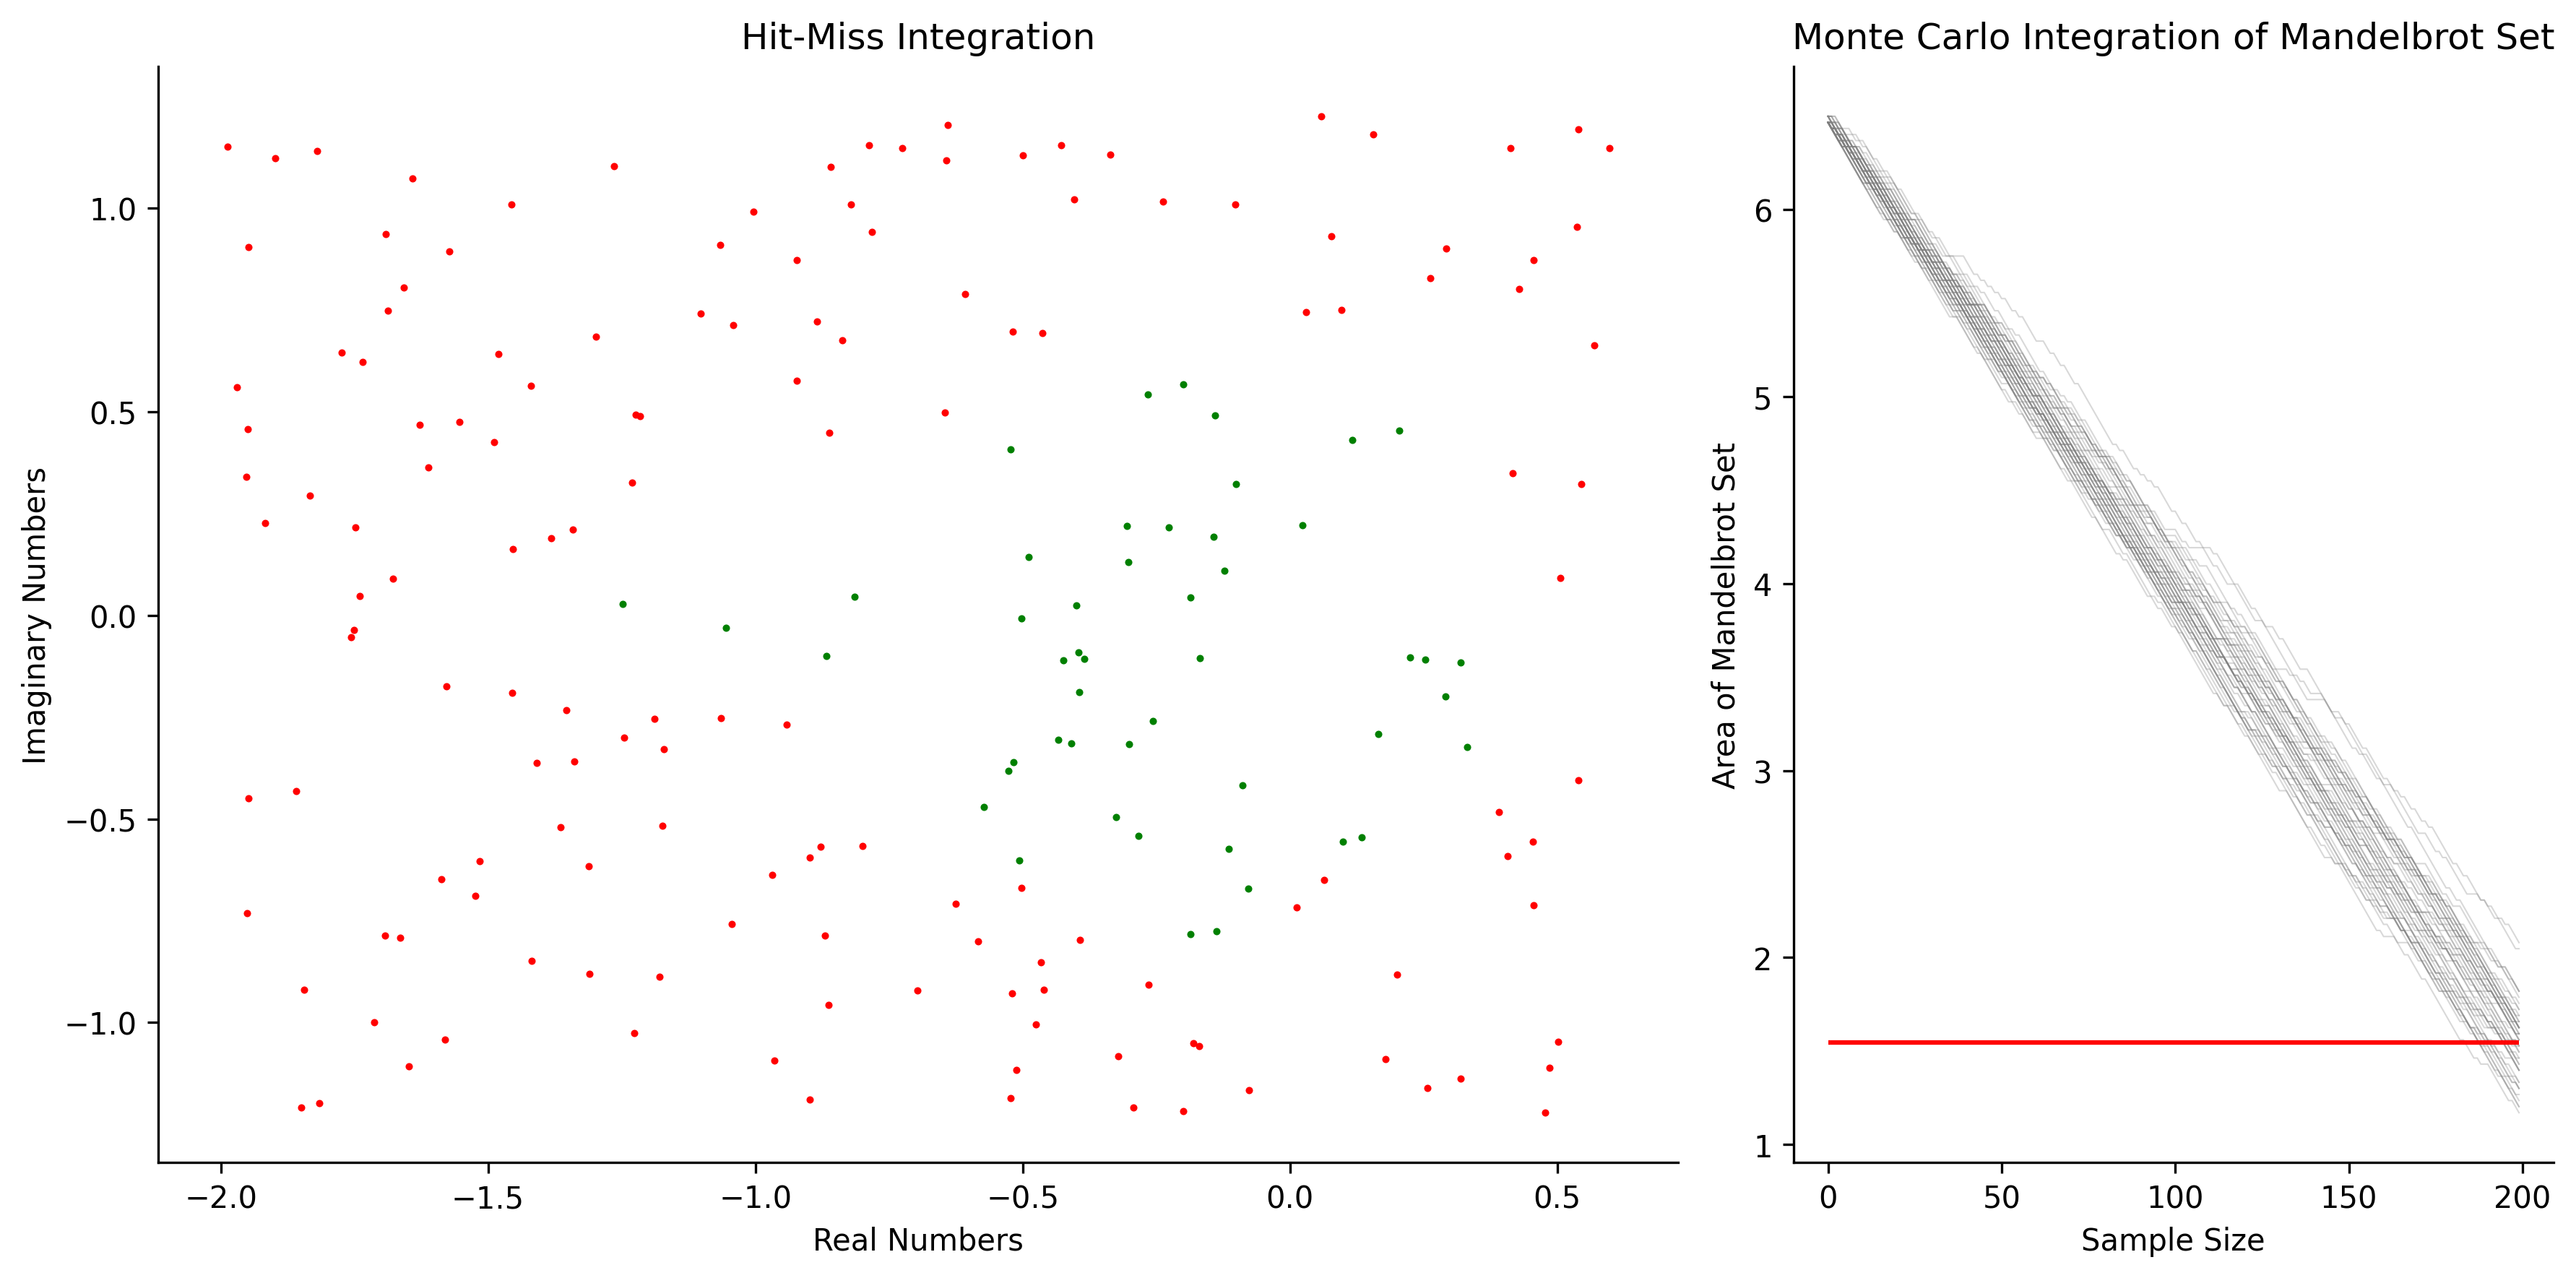

In [339]:
# Create a figure and use GridSpec to control the plot size ratios
fig = plt.figure(figsize=(12, 6), dpi=300)
gs = GridSpec(1, 2, width_ratios=[2, 1], figure=fig)  # Set width ratio to make second plot smaller

# Subplot 1: Line plot for infection peak reduction
ax1 = fig.add_subplot(gs[0])


ax1.scatter(x = x0, y= y0, color = 'green', s=2)
ax1.scatter(x = x1, y= y1, color = 'red', s=2)

ax1.set_title('Hit-Miss Integration', fontsize=12) #idk of hit-miss de passende naam is? dat nog uitzoeken of zeg mc area simulation mandelbrot
ax1.set_xlabel('Real Numbers')  # real axis
ax1.set_ylabel('Imaginary Numbers') # imaginary axis

ax2 = fig.add_subplot(gs[1])
for i in range(num_iter):
	ax2.plot(duration, area_mc[i], alpha=0.3, color = 'grey', lw =0.5)
#ax2.clabel(contours, inline=True, fontsize=8)
ax2.hlines(np.mean(area_mc[:,num_samples-1]), xmin=0, xmax=num_samples-1, color = 'red') #mby de echte opzoeken op het internet)

ax2.set_ylabel("Area of Mandelbrot Set")
ax2.set_xlabel("Sample Size")
ax2.set_title("Monte Carlo Integration of Mandelbrot Set")

# Remove unnecessary spines from both subplots
#? what is a spine?
#ans: Spines are the black lines at the top and right of the plot. It has nothing to do with the simulations. Its visually different ~ Job
for ax in [ax1, ax2]:
	ax.spines['top'].set_visible(False)
	ax.spines['right'].set_visible(False)

# Adjust layout for better spacing
plt.tight_layout()

# Save the figure with high resolution (300 DPI)
plt.savefig('combined_plot_with_labels.png', dpi=300)
plt.show()

In [120]:
area_mc

array([[1.5665 , 1.5665 , 1.5665 , ..., 1.5665 , 1.5665 , 1.5665 ],
       [1.51125, 1.51125, 1.51125, ..., 1.51125, 1.51125, 1.51125],
       [1.534  , 1.534  , 1.534  , ..., 1.534  , 1.534  , 1.534  ],
       ...,
       [1.58275, 1.58275, 1.58275, ..., 1.58275, 1.58275, 1.58275],
       [1.651  , 1.651  , 1.651  , ..., 1.651  , 1.651  , 1.651  ],
       [1.48525, 1.48525, 1.48525, ..., 1.48525, 1.48525, 1.48525]])

In [100]:
np.mean(area_mc[:,-1])

1.5474875000000001

In [82]:
area_mc[:, -1]

array([1.326 , 1.56  , 1.313 , 1.5795, 1.5405, 1.638 , 1.6445, 1.5015,
       1.729 , 1.664 , 1.4885, 1.534 , 1.547 , 1.378 , 1.5275, 1.5015,
       1.599 , 1.69  , 1.5275, 1.5925, 1.5665, 1.508 , 1.521 , 1.508 ,
       1.6055, 1.56  , 1.3975, 1.547 , 1.4755, 1.5145, 1.599 , 1.5665,
       1.443 , 1.6965, 1.4625, 1.443 , 1.586 , 1.6055, 1.521 , 1.534 ,
       1.625 , 1.7615, 1.4625, 1.625 , 1.612 , 1.534 , 1.664 , 1.534 ,
       1.5535, 1.521 , 1.6315, 1.4365, 1.5665, 1.664 , 1.443 , 1.6055,
       1.3845, 1.5015, 1.4625, 1.5795, 1.6445, 1.599 , 1.625 , 1.5145,
       1.612 , 1.5405, 1.638 , 1.495 , 1.716 , 1.4625, 1.4755, 1.612 ,
       1.5405, 1.4625, 1.625 , 1.391 , 1.534 , 1.495 , 1.5535, 1.521 ,
       1.391 , 1.5405, 1.4495, 1.573 , 1.69  , 1.482 , 1.404 , 1.495 ,
       1.443 , 1.404 , 1.521 , 1.3   , 1.56  , 1.586 , 1.4885, 1.4625,
       1.5405, 1.404 , 1.5925, 1.625 , 1.482 , 1.612 , 1.625 , 1.677 ,
       1.586 , 1.599 , 1.508 , 1.508 , 1.5145, 1.6835, 1.495 , 1.443 ,
      